In [177]:
import reactord as rd
import reactord.flowreactors.stationary_1d.pfr as pfr

import numpy as np

import matplotlib.pyplot as plt

### Definicion de las substancias

In [178]:
a = rd.Substance.from_thermo_database(name="methane", thermo_identification="methane")
b = rd.Substance.from_thermo_database(name="ethane", thermo_identification="ethane")
c = rd.Substance.from_thermo_database(name="hydrogen", thermo_identification="hydrogen")

### Definicion de la mezcla

In [179]:
mix = rd.mix.IdealGas([a, b, c])

### Definicion de kinetics

In [180]:
def ra(concentrations, temperature):
    ra = 0.05 * concentrations[0]
    return ra

stoichiometry = np.array([-2, 1, 1])

kinetic = rd.Kinetics(mix, [ra], stoichiometry)

### Definicion de balances

In [181]:
mb = pfr.mass_balances.MolarFlow(
    molar_flows_in={"methane": 0.01, "ethane": 0, "hydrogen": 0},
    molar_flows_out={}
)

eb = pfr.energy_balances.Isothermic(400)

pb = pfr.pressure_balances.Isobaric(1_000_000)

### Definicion del reactor

In [182]:
reactor1 = pfr.PFR(
    mix = mix,
    kinetics = kinetic,
    reactor_length = 0.002,
    transversal_area = 0.05,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb
)

### El repr() del reactor te devuelve el latex de los balances

In [183]:
reactor1

\frac{1}{a_t}\frac{dF_i}{dz}=r_i
\frac{dT}{dz}=0
\frac{dT_r}{dz}=0
\frac{dP}{dz}=0

### El irepr del reactor te renderiza los latex si estas en un entorno interactivo

In [184]:
reactor1.irepr

Mass balance:


\frac{1}{a_t}\frac{dF_i}{dz}=r_i

Reactor and refrigerant energy balances:


\frac{dT}{dz}=0

\frac{dT_r}{dz}=0

Pressure balance:


\frac{dP}{dz}=0

### Simulamos el reactor

In [185]:
reactor1.simulate(tol = 0.001, max_nodes = 1000, verbose = 1)

Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 4.16e-07 
Maximum boundary residual: 1.73e-18


In [186]:
reactor1.sim_df

,z,methane,ethane,hydrogen,temperature,pressure
0,0.000000,0.010000,0.000000,0.000000,400.0,1000000.0
1,0.000020,0.009970,0.000015,0.000015,400.0,1000000.0
2,0.000040,0.009939,0.000030,0.000030,400.0,1000000.0
3,0.000061,0.009909,0.000045,0.000045,400.0,1000000.0
4,0.000081,0.009879,0.000060,0.000060,400.0,1000000.0
...,...,...,...,...,...,...
95,0.001919,0.007494,0.001253,0.001253,400.0,1000000.0
96,0.001939,0.007471,0.001265,0.001265,400.0,1000000.0
97,0.001960,0.007448,0.001276,0.001276,400.0,1000000.0
98,0.001980,0.007426,0.001287,0.001287,400.0,1000000.0


### Ergun pressure balance

In [187]:
mb = pfr.mass_balances.MolarFlow(
    molar_flows_in={"methane": 0.01, "ethane": 0, "hydrogen": 0},
    molar_flows_out={}
)

eb = pfr.energy_balances.Isothermic(400)

pb = pfr.pressure_balances.Ergun(
    pressure = {"in": 1_000_000}, 
    porosity = 0.005, 
    particle_diameter = 0.00001)

reactor2 = pfr.PFR(
    mix = mix,
    kinetics = kinetic,
    reactor_length = 0.02,
    transversal_area = 0.05,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb
)

In [188]:
reactor2.irepr

Mass balance:


\frac{1}{a_t}\frac{dF_i}{dz}=r_i

Reactor and refrigerant energy balances:


\frac{dT}{dz}=0

\frac{dT_r}{dz}=0

Pressure balance:


\frac{dP}{dz}=-\frac{G}{{\rho}D_p}\left(\frac{1-\phi}{\phi^3}\right)\left[\frac{150(1-\phi)\mu}{D_p}+1.75G\right]

In [189]:
reactor2.simulate(tol = 0.001, max_nodes = 1000, verbose = 1)

Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 6.58e-04 
Maximum boundary residual: 0.00e+00


In [190]:
reactor2.sim_df

,z,methane,ethane,hydrogen,temperature,pressure
0,0.000000,0.010000,0.000000,0.000000,400.0,1000000.000000
1,0.000020,0.009970,0.000015,0.000015,400.0,997722.285251
2,0.000040,0.009940,0.000030,0.000030,400.0,995445.538122
3,0.000061,0.009910,0.000045,0.000045,400.0,993169.754288
4,0.000081,0.009880,0.000060,0.000060,400.0,990894.929445
...,...,...,...,...,...,...
95,0.001919,0.007728,0.001136,0.001136,400.0,787392.114325
96,0.001939,0.007710,0.001145,0.001145,400.0,785189.274288
97,0.001960,0.007692,0.001154,0.001154,400.0,782987.061191
98,0.001980,0.007673,0.001163,0.001163,400.0,780785.472088


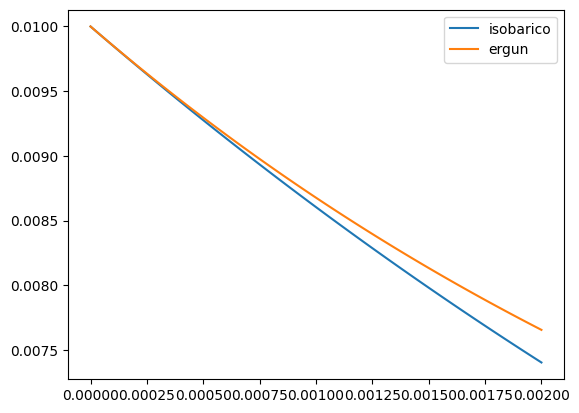

In [191]:
plt.plot(reactor1.sim_df["z"], reactor1.sim_df["methane"], label="isobarico")
plt.plot(reactor2.sim_df["z"], reactor2.sim_df["methane"], label="ergun")

plt.legend()